In [1]:
import tensorflow as tf
import os
from src.utils import reload_model_from_epoch
from src.modeling.preprocess import load, resize, load_image_and_sketch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# inception_model = tf.keras.applications.InceptionV3(include_top=False, 
#                               weights="imagenet", 
#                               pooling='avg')

In [3]:
# def compute_embeddings(dataloader, count):
#     image_embeddings = []


#     for _ in tqdm(range(count)):
#         images = next(iter(dataloader))
#         embeddings = inception_model.predict(images)


#         image_embeddings.extend(embeddings)


#     return np.array(image_embeddings)

In [4]:
def split_pair(pair):
    pair_arr = np.array(pair)
    width = pair_arr.shape[1] // 2
    sketch = pair_arr[:, width:]
    image = pair_arr[:, :width]
    
    
    
    return sketch, image

In [5]:
def rescale(image, factor = 255):
    image = image.astype(float)
    image = image / factor
    
    return image

In [6]:
def convert_to_tensor(image):
    tensor = tf.convert_to_tensor(image)
    tensor = tf.expand_dims(tensor, axis = -1)
    tensor = tf.expand_dims(tensor, axis = 0)
    tensor = tf.cast(tensor, tf.float32)
    
    return tensor

In [7]:
def generate_image(generator, sketch_tensor):
    prediction = generator(sketch_tensor, training = True)
    
    prediction_numpy = (prediction[0, :, :, 0] * 255).numpy()
    prediction_numpy[prediction_numpy < 0] = 0
    
    prediction_image = Image.fromarray(prediction_numpy.astype(np.uint8))
    
    return prediction_image

In [16]:
def save_generated_image(image, end_dir, image_name):
    if not os.path.exists(end_dir):
        os.mkdir(end_dir)
    image.save(end_dir + '/' + image_name)
    
    return

In [10]:
def generate_and_save_image(image_path, generator, end_dir, epoch, model, save = True):
    im = Image.open(image_path)
    
    print('Converting image.')
    
    sketch, image = split_pair(im)
    sketch = rescale(sketch)
    sketch = convert_to_tensor(sketch)
    
    print('Generating prediction.')
    
    prediction_image = generate_image(generator, sketch)

    image_name = f'Generated_Owl_Model_{model.title()}_Epoch_{epoch:03d}_{image_path[-8:-4]}.jpg'
    
    if save:
        print('Saving image.')

        save_generated_image(prediction_image, end_dir, image_name)

        print(f'{image_name} saved to {end_dir}')
    
    return prediction_image

In [11]:
base_path = '..'

In [ ]:
datasets = ['train', 'test']
models = ['pix2pix', 'autopainter']
epochs = np.arange(10, 200, 10)

for dataset in datasets:
    print(f'Generating images from {dataset}.')
    data = os.listdir(f'{base_path}/data/{dataset}')
    for model in models:
        print(f'Generating images using {model}.')
        for epoch in epochs:
            print(f'Generating images using epoch {epoch}.')
            epoch_dir = f'{base_path}/models/{model}/epoch_{epoch:03d}'
            generator = reload_model_from_epoch(epoch_dir, model, base_path)[0]
            
            for image in data:
                print(f'Generating image for {image}.')
                end_dir = f'{base_path}/data/generated/{dataset}/{model}/epoch_{epoch}'
                image_path = f'{base_path}/data/{dataset}/{image}'
                generate_and_save_image(image_path, generator, end_dir, epoch, model)

Generating images from train.
Generating images using pix2pix.
Generating images using epoch 10.
Generating image for Owl_Pair_2704.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2704.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1706.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1706.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2801.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2801.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0919.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0919.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2873.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_28

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2665.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0047.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0047.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2128.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2128.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0828.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0828.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0795.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0795.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1752.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1935.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1290.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1290.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2750.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2750.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1326.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1326.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1163.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1163.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0081.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0876.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1058.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1058.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1702.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1702.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2020.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2020.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0105.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0105.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2513.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1563.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2565.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2565.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1663.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1663.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2829.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2829.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0665.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0665.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1573.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2814.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1627.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1627.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2770.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2770.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0966.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0966.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0786.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0786.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1032.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1373.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0841.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0841.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1331.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1331.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1710.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1710.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2122.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2122.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1905.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2433.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0810.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0810.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0559.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0559.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1595.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1595.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0298.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0298.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2648.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1135.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1012.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1012.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2849.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2849.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2291.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2291.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0114.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0114.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1546.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1303.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2233.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2233.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0870.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0870.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0208.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0208.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0411.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0411.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1403.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0415.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2231.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2231.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1896.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1896.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0880.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0880.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2294.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2294.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2025.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2413.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0831.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0831.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0598.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0598.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0173.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0173.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2439.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2439.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1609.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0194.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1063.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1063.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0917.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0917.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2002.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2002.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1681.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1681.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1462.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1952.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0969.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0969.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0747.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0747.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0874.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0874.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1180.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1180.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2249.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0774.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0270.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0270.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1056.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1056.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1161.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1161.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1762.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1762.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0735.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0035.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0352.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0352.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0426.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0426.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2514.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2514.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0089.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0089.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0867.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1359.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0557.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0557.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1844.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1844.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2519.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2519.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2444.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2444.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2322.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0462.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0266.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0266.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1649.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1649.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2016.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2016.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0539.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0539.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1709.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1042.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2587.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2587.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1348.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1348.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2113.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2113.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2555.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2555.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1449.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0542.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2762.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2762.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1061.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1061.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2678.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2678.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0836.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0836.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2224.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2070.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2454.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2454.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2863.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2863.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2190.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2190.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0717.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0717.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2148.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2388.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1961.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1961.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0861.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0861.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1537.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1537.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2619.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2619.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0477.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2447.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0868.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0868.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2107.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2107.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0495.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0495.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1657.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1657.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1392.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1148.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2870.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2870.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1325.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1325.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0696.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0696.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1639.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1639.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2040.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1410.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2151.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2151.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1664.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1664.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2867.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2867.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1431.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1431.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0783.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1733.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0350.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0350.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1478.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1478.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2099.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2099.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0620.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0620.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2119.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1860.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0873.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0873.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2205.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2205.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1625.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1625.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2875.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2875.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2052.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1962.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2323.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2323.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0820.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0820.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2310.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2310.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0898.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0898.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1320.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1011.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1501.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1501.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1416.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1416.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2080.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2080.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0395.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0395.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1903.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2684.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1023.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1023.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0809.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0809.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0915.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0915.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2752.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2752.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1626.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0573.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2485.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2485.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1981.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1981.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1699.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1699.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0323.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0323.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2165.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0305.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0808.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0808.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0109.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0109.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2570.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2570.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2445.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2445.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0484.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0965.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2751.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2751.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0621.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0621.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1993.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1993.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2790.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2790.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0162.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2183.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0502.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0502.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0168.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0168.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1097.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1097.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1522.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1522.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0875.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0143.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2141.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2141.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1218.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1218.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0846.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0846.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0080.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0080.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0679.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1499.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1493.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1493.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0906.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0906.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1600.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1600.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2874.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2874.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1847.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2288.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0134.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0134.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0844.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0844.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0839.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0839.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0125.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0125.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2537.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1201.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2071.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2071.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2846.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2846.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2674.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2674.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0862.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0862.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2672.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1680.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1423.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1423.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0360.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0360.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2285.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2285.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0106.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0106.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2239.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2257.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0890.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0890.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1232.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1232.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0456.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0456.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0037.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0037.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1998.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1687.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0574.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0574.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1387.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1387.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0982.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0982.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0686.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0686.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1409.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0339.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2505.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2505.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1467.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1467.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0942.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0942.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0002.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0002.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1030.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0202.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0316.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0316.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0334.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0334.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1867.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1867.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1281.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1281.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2865.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1807.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2748.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2748.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0583.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0583.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_0959.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_0959.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2419.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2419.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2357.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1400.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2424.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2424.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2529.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2529.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_1301.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_1301.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2725.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_010_2725.jpg saved to ../data/generated/train/pix2pix/epoch_10
Generating image for Owl_Pair_2618.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1221.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0514.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0514.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2531.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2531.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1488.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1488.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1986.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1986.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0434.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1761.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2772.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2772.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0605.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0605.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0784.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0784.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0374.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0374.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0250.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0070.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0214.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0214.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1487.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1487.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1323.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1323.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1255.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1255.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0218.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2368.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2228.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2228.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2659.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2659.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2140.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2140.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2062.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2062.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1111.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2482.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0468.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0468.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2634.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2634.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1590.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1590.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1505.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1505.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0231.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2395.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2189.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2189.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2229.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2229.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0989.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0989.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1445.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1445.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1693.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2248.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1805.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1805.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1178.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1178.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1669.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1669.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0058.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0058.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0512.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0151.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1486.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1486.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1159.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1159.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1366.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1366.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2272.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2272.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0749.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1923.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2622.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2622.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0180.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0180.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1512.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1512.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2588.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2588.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2670.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0023.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0517.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0517.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1731.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1731.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1946.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1946.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2459.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2459.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0167.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1735.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0095.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0095.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2194.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2194.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0604.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0604.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0362.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0362.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0987.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0365.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1047.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1047.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1736.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1736.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2024.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2024.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0493.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0493.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1295.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2109.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1034.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1034.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1904.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1904.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1816.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1816.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0704.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0704.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0024.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0147.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0046.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0046.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0743.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0743.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2533.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2533.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1225.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1225.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1029.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2095.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2544.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2544.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0385.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0385.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0713.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0713.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1607.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1607.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2008.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0205.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2319.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2319.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0113.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0113.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0837.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0837.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0150.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0150.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0343.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1184.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1722.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1722.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0179.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0179.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1009.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1009.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0390.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0390.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1772.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1128.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1363.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1363.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2577.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2577.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0126.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0126.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2774.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2774.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0461.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0903.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0901.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0901.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2457.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2457.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2742.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2742.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0182.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0182.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0096.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0284.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0789.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0789.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2756.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2756.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0079.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0079.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2351.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2351.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1811.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0680.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1412.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1412.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1138.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1138.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1818.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1818.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1551.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1551.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0920.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2510.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0606.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0606.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2286.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2286.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0226.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0226.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0381.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0381.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0172.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1959.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1070.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1070.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2057.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2057.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2492.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2492.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1427.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1427.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2032.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2699.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1884.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1884.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1129.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1129.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1694.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1694.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1276.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1276.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2834.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2335.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0907.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0907.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2406.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2406.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1372.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1372.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1868.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1868.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2423.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1173.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2777.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2777.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2740.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2740.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1940.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1940.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1396.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1396.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0092.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1589.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2186.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2186.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0246.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0246.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0377.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0377.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2075.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2075.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1278.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1164.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0590.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0590.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2115.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2115.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0519.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0519.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2841.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2841.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2465.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1196.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0500.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0500.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1758.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1758.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1533.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1533.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0522.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0522.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0457.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1231.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0506.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0506.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2391.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2391.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2429.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2429.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0630.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0630.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2578.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0594.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2003.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2003.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2669.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2669.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0479.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0479.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0546.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0546.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2204.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2163.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1119.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1119.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0996.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0996.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1769.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1769.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2682.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2682.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0646.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1877.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1253.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1253.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1123.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1123.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1263.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1263.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2004.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2004.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0737.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0757.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0924.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0924.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0726.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0726.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0212.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0212.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0693.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0693.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0354.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0562.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1121.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1121.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_1041.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_1041.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_2543.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_2543.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0904.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pix_Epoch_020_0904.jpg saved to ../data/generated/train/pix2pix/epoch_20
Generating image for Owl_Pair_0736.jpg.
Converting image.
Generating prediction.
Saving image.
Generated_Owl_Model_Pix2Pi

In [90]:
im = Image.open(f'{base_path}/data/test/Owl_Pair_0607.jpg')
epoch_dir = f'{base_path}/models/pix2pix/epoch_200'
generator = reload_model_from_epoch(epoch_dir, 'pix2pix', base_path)[0]

In [93]:
sketch, image = split_pair(im)
format_sketch = rescale(sketch)
format_sketch = convert_to_tensor(format_sketch)
prediction_image = generate_image(generator, format_sketch)

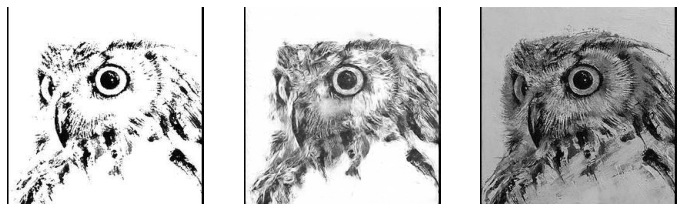

In [97]:
fig, ax = plt.subplots(1, 3, figsize = (12, 8))

ax[0].imshow(sketch, cmap = 'gray');
ax[1].imshow(prediction_image, cmap = 'gray');
ax[2].imshow(image, cmap = 'gray');

ax[0].axis('off');
ax[1].axis('off');
ax[2].axis('off');